# Spellcheck LLM dengan Ollama di Google Colab

Notebook ini melakukan koreksi ejaan pada kalimat Bahasa Indonesia menggunakan LLM (Ollama) dan menghitung akurasi hasil koreksi.

In [ ]:
# --- SETUP: Install dependencies dan Ollama OPTIONAL If you are using Google Colab ---
# --- Change http://host.docker.internal:11434  to http://localhost:11434 if you are using Google Colab or Localhost ---
!curl -fsSL https://ollama.com/install.sh | sh
!ollama serve &
!ollama pull llama3

In [12]:
! pip install ipywidgets pandas requests matplotlib numpy Levenshtein

import ipywidgets as widgets
from IPython.display import display
import pandas as pd

uploader = widgets.FileUpload(accept='.csv', multiple=False)
process_button = widgets.Button(description="Proses File")
output = widgets.Output()

# Add dropdown for error type selection
error_type_dropdown = widgets.Dropdown(
    options=[
        ('Umum (Semua Error)', 'correct_spelling'),
        ('Error Deletion', 'deletion_error'),
        ('Error Insertion', 'insertion_error'),
        ('Error Punctuation', 'punctuation_error'),
        ('Error Real Word', 'real_word_error'),
        ('Error Substitution', 'subtitution_error'),
        ('Error Transposition', 'transposition_error')
    ],
    value='deletion_error',
    description='Tipe Error:',
    style={'description_width': '120px'},
    layout={'width': '350px'}
)

# Add dropdown for model selection
model_dropdown = widgets.Dropdown(
    options=[
        ('llama3.1:8b', 'llama3.1:8b'),
        ('llama3.2:8b', 'llama3.2:8b'),
        ('gemma:7b', 'gemma:7b')
    ],
    value='llama3.1:8b',
    description='Model LLM:',
    style={'description_width': '120px'},
    layout={'width': '350px'}
)

# Gunakan variabel global agar bisa diakses di cell lain
uploaded_filename = None
selected_error_type = None
selected_model = None

def on_process_clicked(b):
    global uploaded_filename, selected_error_type, selected_model
    with output:
        output.clear_output()
        if uploader.value:
            file_info = uploader.value[0]
            uploaded_filename = file_info['name']
            selected_error_type = error_type_dropdown.value
            selected_model = model_dropdown.value
            # Simpan ke disk lokal
            with open(uploaded_filename, 'wb') as f:
                f.write(file_info['content'])
            print(f"File berhasil disimpan sebagai: {uploaded_filename}")
            print(f"Tipe error yang akan dikoreksi: {selected_error_type}")
            print(f"Model LLM yang akan digunakan: {selected_model}")
        else:
            print("Belum ada file yang di-upload.")

# Display the widgets with the new dropdowns
display(widgets.VBox([
    widgets.HBox([widgets.Label('Pilih File CSV:'), uploader]),
    error_type_dropdown,
    model_dropdown,
    process_button, 
    output
]))

process_button.on_click(on_process_clicked)

## 1. Dataset & Utilitas Data

In [13]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

class SpellingDataset:
    def __init__(self, error_sentences=None, correct_sentences=None):
        self.error_sentences = error_sentences or []
        self.correct_sentences = correct_sentences or []
    def add_sample(self, error_sentence, correct_sentence):
        self.error_sentences.append(error_sentence)
        self.correct_sentences.append(correct_sentence)
    def get_all_samples(self):
        return list(zip(self.error_sentences, self.correct_sentences))
    def __len__(self):
        return len(self.error_sentences)

def get_sample_indonesian_dataset(csv_path):
    print(f"Loading dataset from {csv_path}")
    df = pd.read_csv(csv_path)
    dataset = SpellingDataset()
    for _, row in df.iterrows():
        dataset.add_sample(row['kalimat_salah'], row['kalimat_awal'])
    return dataset

if uploaded_filename:
    dataset = get_sample_indonesian_dataset(uploaded_filename)
    kalimat_salah = dataset.error_sentences
    kalimat_benar = dataset.correct_sentences
    print(f"Jumlah data: {len(dataset)}")
else:
    print("File belum di-upload atau diproses.")


Loading dataset from IPS_output_transposition_error.csv
Jumlah data: 500


## 2. Client Ollama untuk Koreksi Ejaan

In [14]:
import requests

class OllamaClient:
    def __init__(self, base_url="http://host.docker.internal:11434"):
        self.base_url = base_url
        self.api_endpoint = f"{self.base_url}/api/generate"
    
    def deletion_error(self, text, model="llama3.2", system_prompt=None):
        if system_prompt is None:
            system_prompt = f"""
                You are an assistant who helps to correct the spelling of Indonesian sentences. Focus on correcting deletion errors as your top priority. 

                DO: Return only the corrected sentences.
                
                DONT: Do not add explanations, do not add or remove other words, and do not change context of sentence.

                Deletion Error (Top Priority) Identify and correct deletion letters in words.
                EXAMPLE 1 :
                - User: Apakah teks tersebut termsuk teks deskripsi?
                - Assistant: Apakah teks tersebut termsuk teks deskripsi?
                
                - User: Memilih objek yang ada di sekitar temat kalian, dapat membantu kalian dalam kegiatan ini.
                - Assistant: Memilih objek yang ada di sekitar tempat kalian, dapat membantu kalian dalam kegiatan ini.

                - User: Tentukan rincian apa saja dari objek yan akan kalian deskripsikan itu.
                - Assistant: Tentukan rincian apa saja dari objek yang akan kalian deskripsikan itu.

                - User: Kalian dapat melihat kembali info yang memparkan tentang deskripsi bagian dalam teks deskripsi.
                - Assistant: Kalian dapat melihat kembali info yang memaparkan tentang deskripsi bagian dalam teks deskripsi.

                """
            
        payload = {
            "model": model,
            "prompt": text,
            "system": system_prompt,
            "stream": False,
            "temperature": 0.1,
        }
        try:
            response = requests.post(self.api_endpoint, json=payload)
            response.raise_for_status()
            result = response.json()
            return result["response"].strip()
        except Exception as e:
            print(f"Gagal koreksi: {e}")
            return ""
    
    def insertion_error(self, text, model="llama3.2", system_prompt=None):
        if system_prompt is None:
            system_prompt = f"""
                You are an assistant who helps to correct the spelling of Indonesian sentences. Focus on correcting insertion errors as your top priority. 

                DO: Return only the corrected sentences.

                DONT: Do not add explanations, do not add or remove other words, and do not change context of sentence.

                Insertion Error (Top Priority) Identify and correct insertion letters in words.
                EXAMPLE 1 :
                - User: Apa saja perasaan yang terlihat pada gambtar?
                - Assistant: Apa saja perasaan yang terlihat pada gambar?
                
                - User: Amati gambar di atoas bersama guru.
                - Assistant: Amati gambar di atas bersama guru.
                
                - User: Berapa jumlah anak dio dalam gambar?
                - Assistant: Berapa jumlah anak di dalam gambar?
                
                - User: Sebutkan perasaan yang dialami oleh anak-anak dalatm gambar.
                - Assistant: Sebutkan perasaan yang dialami oleh anak-anak dalam gambar.
                """
        
        payload = {
            "model": model,
            "prompt": text,
            "system": system_prompt,
            "stream": False,
            "temperature": 0.1,
        }
        try:
            response = requests.post(self.api_endpoint, json=payload)
            response.raise_for_status()
            result = response.json()
            return result["response"].strip()
        except Exception as e:
            print(f"Gagal koreksi: {e}")
            return ""
    
    def punctuation_error(self, text, model="llama3.2", system_prompt=None):
        if system_prompt is None:
            system_prompt = f"""
                You are an assistant who helps to correct the spelling of Indonesian sentences. Focus on correcting punctuation errors as your top priority. 

                DO: Return only the corrected sentences.

                DONT: Do not add explanations, do not add or remove other words, and do not change context of sentence.

                Punctuation Error (Top Priority) Identify and correct punctuation in sentences.
                EXAMPLE 1 :
                - User: Menulis resensi tidaklah mudah'
                - Assistant: Menulis resensi tidaklah mudah.
                
                - User: Penulis harus memiliki pengetahuan di bidangnya'
                - Assistant: Penulis harus memiliki pengetahuan di bidangnya.
                 
                - User: Artinya, jika seorang penulis akan meresensi sebuah novel, maka ia harus memiliki pengetahuan tentang teori novel dan perkembangannya@
                - Assistant: Artinya, jika seorang penulis akan meresensi sebuah novel, maka ia harus memiliki pengetahuan tentang teori novel dan perkembangannya.
                 
                - User: Penulis harus memiliki kemampuan menganalisis'
                - Assistant: Penulis harus memiliki kemampuan menganalisis.
                """
        
        payload = {
            "model": model,
            "prompt": text,
            "system": system_prompt,
            "stream": False,
            "temperature": 0.1,
        }
        try:
            response = requests.post(self.api_endpoint, json=payload)
            response.raise_for_status()
            result = response.json()
            return result["response"].strip()
        except Exception as e:
            print(f"Gagal koreksi: {e}")
            return ""
    
    def real_word_error(self, text, model="llama3.2", system_prompt=None):
        if system_prompt is None:
            system_prompt = f"""
                You are an assistant who helps to correct the spelling of Indonesian sentences. Focus on correcting real word errors as your top priority. 

                DO: Return only the corrected sentences.

                DONT: Do not add explanations, do not add or remove other words, and do not change context of sentence.

                Real Word Error (Top Priority) Identify and correct real word errors in sentences.
                EXAMPLE 1 :
                - User: Siapa uang menolong dia?
                - Assistant: Siapa yang menolong dia?

                - User: Hore! bab terakhir susah selesai.
                - Assistant: Hore! bab terakhir sudah selesai.

                - User: Saya dapat mengenali tanda-tanda salam peta.
                - Assistant: Saya dapat mengenali tanda-tanda dalam peta.

                - User: Saya dapat mengenali petugas berseragam di sekitar sayu.
                - Assistant: Saya dapat mengenali petugas berseragam di sekitar saya.
                """

        payload = {
            "model": model,
            "prompt": text,
            "system": system_prompt,
            "stream": False,
            "temperature": 0.1,
        }

        try:
            response = requests.post(self.api_endpoint, json=payload)
            response.raise_for_status()
            result = response.json()
            return result["response"].strip()
        except Exception as e:
            print(f"Gagal koreksi: {e}")
            return ""

    def subtitution_error(self, text, model="llama3.2", system_prompt=None):
        if system_prompt is None:
            system_prompt = f"""
                You are an assistant who helps to correct the spelling of Indonesian sentences. Focus on substitution errors as your top priority.

                DO: Return only the corrected sentences.

                DONT: Do not add explanations, do not add or remove other words, and do not change context of sentence.

                Substitution Error (Top Priority) Identify and correct substitution errors in sentences.
                EXAMPLE 1 :
                - User: Buatlah sebuah peta beupikir bersama guru.
                - Assistant: Buatlah sebuah peta berpikir bersama guru.
                
                - User: Tuliskan penyebab rasa taqut kalian.
                - Assistant: Tuliskan penyebab rasa takut kalian.
                
                - User: Kalian juga boleh menambahkav gambar.
                - Assistant: Kalian juga boleh menambahkan gambar.
                 
                - User: Apa yang kalian lakukan saat merasa sediy?
                - Assistant: Apa yang kalian lakukan saat merasa sedih?
                """

        payload = {
            "model": model,
            "prompt": text,
            "system": system_prompt,
            "stream": False,
            "temperature": 0.1,
        }
        try:
            response = requests.post(self.api_endpoint, json=payload)
            response.raise_for_status()
            result = response.json()
            return result["response"].strip()
        except Exception as e:
            print(f"Gagal koreksi: {e}")
            return ""
    
    def transposition_error(self, text, model="llama3.2", system_prompt=None):
        if system_prompt is None:
            system_prompt = f"""
                You are an assistant who helps to correct the spelling of Indonesian sentences. Focus on transposition errors as your top priority.

                DO: Return only the corrected sentences.

                DONT: Do not add explanations, do not add or remove other words, and do not change context of sentence.

                Transposition Error (Top Priority) Identify and correct transposition errors in sentences.
                EXAMPLE 1 :
                - User: Menurut kalian, mengapa immi marah?
                - Assistant: Menurut kalian, mengapa mimi marah?
                
                - User: Simaklah petunjuk guru untuk melakukan percobaan sderehana.
                - Assistant: Simaklah petunjuk guru untuk melakukan percobaan sederhana.
                
                - User: Sesudahnya, sampaikan penadpat kalian.
                - Assistant: Sesudahnya, sampaikan pendapat kalian.
                 
                - User: Keadaan mana yang lebih nyaman bagi utbuh kalian?
                - Assistant: Keadaan mana yang lebih nyaman bagi tubuh kalian?
                """
        payload = {
            "model": model,
            "prompt": text,
            "system": system_prompt,
            "stream": False,
            "temperature": 0.1,
        }
        try:
            response = requests.post(self.api_endpoint, json=payload)
            response.raise_for_status()
            result = response.json()
            return result["response"].strip()
        except Exception as e:
            print(f"Gagal koreksi: {e}")
            return ""
    
    def correct_spelling(self, text, model="llama3", system_prompt=None):
        if system_prompt is None:
            system_prompt = (
                "You are an assistant who helps to correct the spelling of Indonesian sentences."
                "Correct only the wrong spelling, do not add explanations, do not add other words or do not add punctuation words."
                "Do not change the explanation, do not change other words or do not change punctuation."
                "Return only the corrected sentences."
            )
        payload = {
            "model": model,
            "prompt": text,
            "system": system_prompt,
            "stream": False,
            "temperature": 0.1,
        }
        try:
            response = requests.post(self.api_endpoint, json=payload)
            response.raise_for_status()
            result = response.json()
            return result["response"].strip()
        except Exception as e:
            print(f"Gagal koreksi: {e}")
            return ""

## 3. Fungsi Evaluasi Akurasi

In [15]:
# Fungsi sederhana untuk mengukur akurasi LLM
import numpy as np

def skema_exact_match(hasil_prediksi, target_benar):

    if len(hasil_prediksi) != len(target_benar):
        raise ValueError("Jumlah prediksi dan target harus sama")
    hasil_per_item = [(pred.strip().lower() == target.strip().lower()) for pred, target in zip(hasil_prediksi, target_benar)]
    akurasi = sum(hasil_per_item) / len(hasil_per_item) if hasil_per_item else 0
    return akurasi, hasil_per_item

def skema_kata_per_kata_debug(hasil_prediksi, target_benar, debug=True):
    if len(hasil_prediksi) != len(target_benar):
        raise ValueError("Jumlah prediksi dan target harus sama")
    
    akurasi_per_kalimat = []
    
    for idx, (pred, target) in enumerate(zip(hasil_prediksi, target_benar)):
        if debug:
            print(f"\n--- Debug kalimat #{idx+1} ---")
            print(f"Prediksi: '{pred}'")
            print(f"Target  : '{target}'")
        
        # Split kalimat menjadi kata-kata dan ubah ke lowercase
        pred_words = [w.lower() for w in pred.split()]
        target_words = [w.lower() for w in target.split()]
        
        if debug:
            print(f"Kata prediksi: {pred_words}")
            print(f"Kata target  : {target_words}")
        
        # Hitung jumlah kata yang benar
        total_words = max(len(pred_words), len(target_words))
        
        if total_words == 0:
            akurasi_kata = 1.0 if pred.strip().lower() == target.strip().lower() else 0.0
            if debug:
                print(f"Kalimat kosong, akurasi: {akurasi_kata}")
        else:
            correct_words = 0
            for i in range(min(len(pred_words), len(target_words))):
                is_correct = pred_words[i] == target_words[i]
                correct_words += 1 if is_correct else 0
                if debug:
                    status = "✓" if is_correct else "✗"
                    print(f"Kata #{i+1}: '{pred_words[i]}' vs '{target_words[i]}' -> {status}")
            
            akurasi_kata = correct_words / total_words
            
            if debug:
                print(f"Kata benar: {correct_words}/{total_words} = {akurasi_kata:.4f}")
                if len(pred_words) != len(target_words):
                    if len(pred_words) > len(target_words):
                        print(f"Extra kata di prediksi: {pred_words[len(target_words):]}")
                    else:
                        print(f"Missing kata di prediksi: {target_words[len(pred_words):]}")
        
        akurasi_per_kalimat.append(akurasi_kata)
    
    avg_akurasi = np.mean(akurasi_per_kalimat) if akurasi_per_kalimat else 0
    
    if debug:
        print("\n--- Ringkasan ---")
        print(f"Akurasi per kalimat: {[round(a, 4) for a in akurasi_per_kalimat]}")
        print(f"Rata-rata akurasi: {avg_akurasi:.4f}")
    
    return avg_akurasi, akurasi_per_kalimat

def skema_kata_per_kata(hasil_prediksi, target_benar):
    if len(hasil_prediksi) != len(target_benar):
        raise ValueError("Jumlah prediksi dan target harus sama")
    
    akurasi_per_kalimat = []
    
    for pred, target in zip(hasil_prediksi, target_benar):
        # Split kalimat menjadi kata-kata dan ubah ke lowercase
        pred_words = [w.lower() for w in pred.split()]
        target_words = [w.lower() for w in target.split()]
        
        # Hitung jumlah kata yang benar
        total_words = max(len(pred_words), len(target_words))
        
        if total_words == 0:
            # Kasus khusus jika kalimat kosong
            akurasi_kata = 1.0 if pred.strip().lower() == target.strip().lower() else 0.0
        else:
            # Hitung kata yang sama pada posisi yang sama
            correct_words = sum(1 for i in range(min(len(pred_words), len(target_words))) 
                             if pred_words[i] == target_words[i])
            akurasi_kata = correct_words / total_words
        
        akurasi_per_kalimat.append(akurasi_kata)
    
    # Rata-rata akurasi dari semua kalimat
    avg_akurasi = np.mean(akurasi_per_kalimat) if akurasi_per_kalimat else 0
    
    return avg_akurasi, akurasi_per_kalimat


## 4. Proses Koreksi Ejaan dengan LLM

In [16]:
import time

client = OllamaClient()
hasil_llm_model = []
processing_times = []

print(f"Using model: {selected_model}")
print(f"Error correction type: {selected_error_type}")

# Define the function to use based on error type - before the loop
if selected_error_type == 'deletion_error':
    correction_prompt = lambda kalimat: f"""Please correct any deletion errors in the following text: {kalimat}"""
    correction_func = client.deletion_error
elif selected_error_type == 'insertion_error':
    correction_prompt = lambda kalimat: f"""Please correct any insertion errors in the following text: {kalimat}"""
    correction_func = client.insertion_error
elif selected_error_type == 'punctuation_error':
    correction_prompt = lambda kalimat: f"""Please correct any punctuation errors in the following text: {kalimat}"""
    correction_func = client.punctuation_error
elif selected_error_type == 'real_word_error':
    correction_prompt = lambda kalimat: f"""Please correct any real word errors (words used incorrectly) in the following text: {kalimat}"""
    correction_func = client.real_word_error
elif selected_error_type == 'subtitution_error':
    correction_prompt = lambda kalimat: f"""Please correct any substitution errors in the following text: {kalimat}"""
    correction_func = client.subtitution_error
elif selected_error_type == 'transposition_error':
    correction_prompt = lambda kalimat: f"""Please correct any transposition errors in the following text: {kalimat}"""
    correction_func = client.transposition_error
else:
    # Default to general spelling correction
    correction_prompt = lambda kalimat: f"""Please correct any spelling errors in the following text: {kalimat}"""
    correction_func = client.correct_spelling

# Now loop through sentences using the selected function
for i, kalimat in enumerate(kalimat_salah):
    print(f"Proses Kalimat ke-{i+1} dari {len(kalimat_salah)}")
    start = time.time()
    
    # Use the pre-selected function and prompt
    hasil = correction_func(
        correction_prompt(kalimat),
        model=selected_model
    )
    
    end = time.time()
    print(f"Kalimat: {kalimat}")
    print(f"Hasil: {hasil}")
    print("=====================================")
    hasil_llm_model.append(hasil) 
    processing_times.append(end-start)

print("====== Selesai Proses  ======")

Using model: llama3.1:8b
Error correction type: transposition_error
Proses Kalimat ke-1 dari 500
Kalimat: Tiap orang punya beand berharga.
Hasil: Tiap orang punya benda berharga.
Proses Kalimat ke-2 dari 500
Kalimat: Bisa juga berpua benda-benda.
Hasil: Benda-benda bisa juga berpuas.
Proses Kalimat ke-3 dari 500
Kalimat: Edokumn harus dijaga dan dirawat.
Hasil: Edokumen harus dijaga dan dirawat.
Proses Kalimat ke-4 dari 500
Kalimat: Benda berharga juga hasru dipelihara.
Hasil: Benda berharga juga harus dipelihara.
Proses Kalimat ke-5 dari 500
Kalimat: Jika dirawat, dokumen dan benda berharga atidk mudah rusak.
Hasil: Jika dirawat, dokumen dan benda berharga tidak mudah rusak.
Proses Kalimat ke-6 dari 500
Kalimat: Guru membimbing anak untuk mengetahui pentingnya mmelihaera dokumen dan koleksi benda berharga diri dan keluarga, sehingga anak bisa menghargainya.
Hasil: Guru membimbing anak untuk mengetahui pentingnya menejaha dokumen dan koleksi benda berharga diri dan keluarga, sehingga a

## 5. Evaluasi & Visualisasi Akurasi

====== Hasil Evaluasi ======
Skema 1 - Exact Match Accuracy : 0.3760
Skema 2 - Word Match Accuracy  : 0.7636
Rata-rata waktu proses         : 0.30s
1. ✓ Kata Benar: 1.00
   Input : Tiap orang punya beand berharga.
   Target: Tiap orang punya benda berharga.
   LLM   : Tiap orang punya benda berharga.
   Waktu Proses: 0.19s

2. ✗ Kata Benar: 0.00
   Input : Bisa juga berpua benda-benda.
   Target: Bisa juga berupa benda-benda.
   LLM   : Benda-benda bisa juga berpuas.
   Waktu Proses: 0.18s

3. ✗ Kata Benar: 0.80
   Input : Edokumn harus dijaga dan dirawat.
   Target: Dokumen harus dijaga dan dirawat.
   LLM   : Edokumen harus dijaga dan dirawat.
   Waktu Proses: 0.19s

4. ✓ Kata Benar: 1.00
   Input : Benda berharga juga hasru dipelihara.
   Target: Benda berharga juga harus dipelihara.
   LLM   : Benda berharga juga harus dipelihara.
   Waktu Proses: 0.19s

5. ✓ Kata Benar: 1.00
   Input : Jika dirawat, dokumen dan benda berharga atidk mudah rusak.
   Target: Jika dirawat, dokumen dan

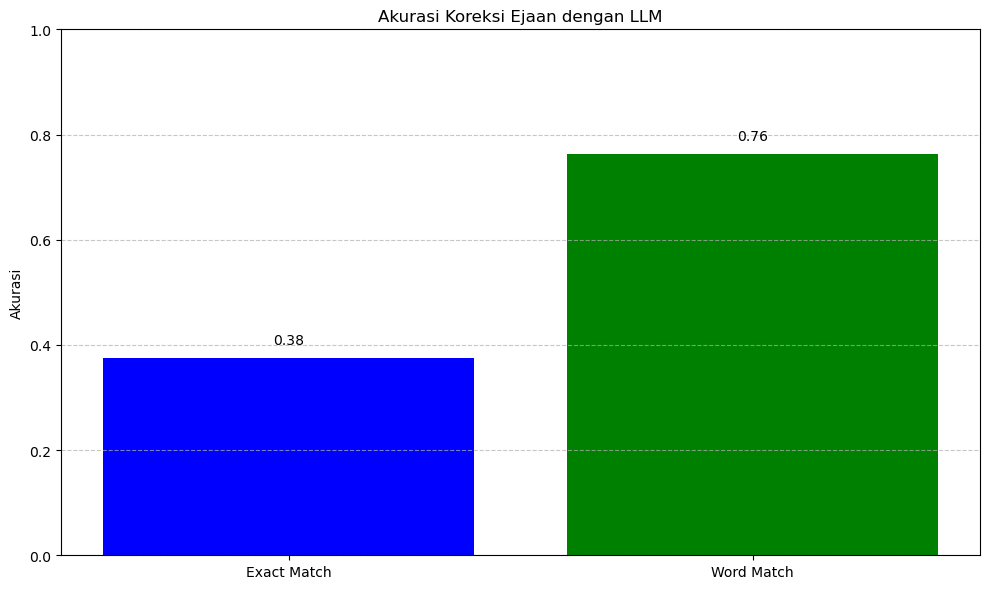

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Hitung akurasi dengan kedua skema
exact_acc, exact_detail = skema_exact_match(hasil_llm_model, kalimat_benar)
kata_acc, kata_detail = skema_kata_per_kata(hasil_llm_model, kalimat_benar)

# Tampilkan hasil akurasi
print(f"====== Hasil Evaluasi ======")
print(f"Skema 1 - Exact Match Accuracy : {exact_acc:.4f}")
print(f"Skema 2 - Word Match Accuracy  : {kata_acc:.4f}")
print(f"Rata-rata waktu proses         : {np.mean(processing_times):.2f}s")

# Buat dataframe untuk menyimpan hasil detail
results_data = []
for i, (salah, benar, hasil, exact, kata_akurasi, process_time) in enumerate(zip(kalimat_salah, kalimat_benar, hasil_llm_model, exact_detail, kata_detail, processing_times)):
    status = "✓" if exact else "✗"
    results_data.append({
        'no': i+1,
        'exact_match': exact,
        'word_accuracy': kata_akurasi,
        'input_sentence': salah,
        'target_sentence': benar,
        'llm_output': hasil,
        'processing_time': process_time
    })
    
    # Print untuk output konsol
    print(f"{i+1}. {status} Kata Benar: {kata_akurasi:.2f}")
    print(f"   Input : {salah}")
    print(f"   Target: {benar}")
    print(f"   LLM   : {hasil}")
    print(f"   Waktu Proses: {process_time:.2f}s\n")

# Buat DataFrame dari hasil
df_results = pd.DataFrame(results_data)

# Simpan ke CSV
output_filename = f"{uploaded_filename}_hasil_koreksi_ejaan.csv"
df_results.to_csv(output_filename, index=False)
print(f"\nHasil detail telah disimpan ke file: {output_filename}")

# Simpan juga ringkasan hasil
summary_data = {
    'Model': [selected_model],
    'Exact_Match_Accuracy': [exact_acc],
    'Word_Match_Accuracy': [kata_acc],
    'Avg_Processing_Time': [np.mean(processing_times)]
}
df_summary = pd.DataFrame(summary_data)
summary_filename = f"{uploaded_filename}_ringkasan_akurasi.csv"
df_summary.to_csv(summary_filename, index=False)
print(f"Ringkasan hasil telah disimpan ke file: {summary_filename}")

# Visualisasi tetap sama seperti sebelumnya
metrics = ['Exact Match', 'Word Match']
values = [exact_acc, kata_acc]
colors = ['blue', 'green']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors)
plt.ylim(0, 1.0)
plt.title('Akurasi Koreksi Ejaan dengan LLM')
plt.ylabel('Akurasi')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan label nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()

# Save the figure before showing it
filename = f"{uploaded_filename}_accuracy.png"
plt.savefig(filename, bbox_inches='tight', dpi=300)
plt.show()

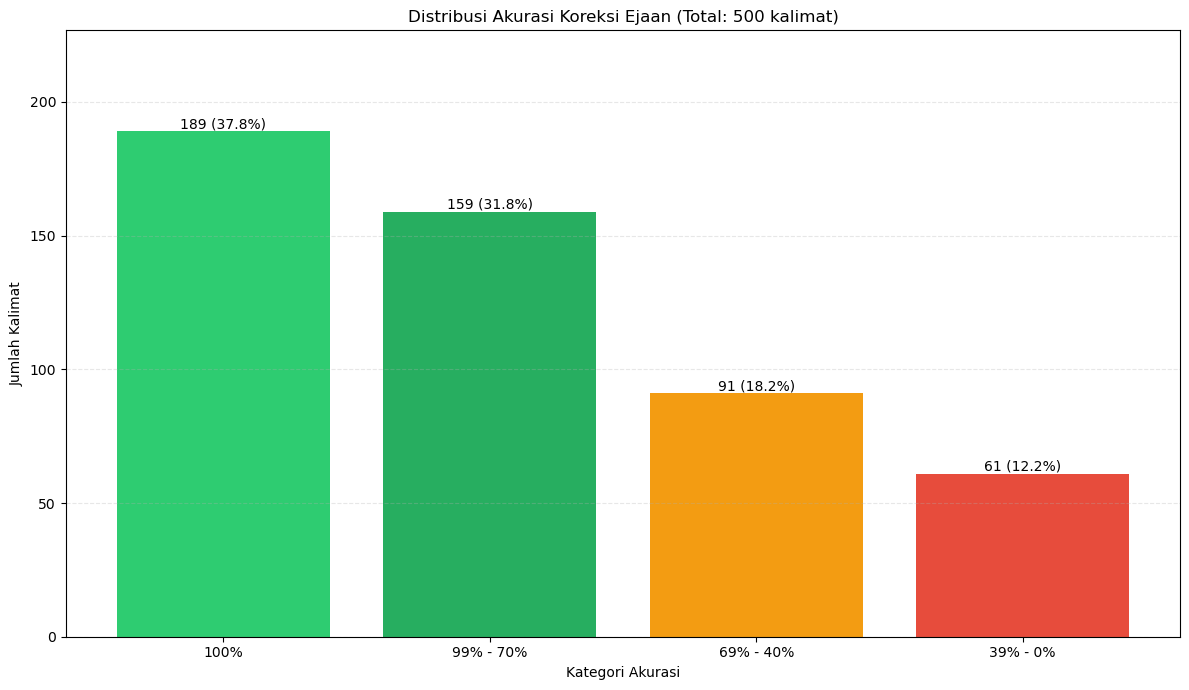

In [19]:
# Visualisasi distribusi akurasi kata berdasarkan kelompok
plt.figure(figsize=(12, 7))

# Definisikan kategori akurasi
categories = ["100%", "99% - 70%", "69% - 40%", "39% - 0%"]
category_ranges = [(1.0, 1.0), (0.7, 0.99), (0.4, 0.69), (0.0, 0.39)]
colors = ['#2ecc71', '#27ae60', '#f39c12', '#e74c3c']  # Warna berbeda untuk tiap kategori

# Hitung jumlah kalimat per kategori
counts = []
for lower, upper in category_ranges:
    count = sum(1 for acc in kata_detail if lower <= acc <= upper)
    counts.append(count)

# Buat bar chart
bars = plt.bar(categories, counts, color=colors)
plt.xlabel('Kategori Akurasi')
plt.ylabel('Jumlah Kalimat')
plt.title('Distribusi Akurasi Koreksi Ejaan')

# Tambahkan label jumlah dan persentase pada setiap bar
total = sum(counts)
for bar in bars:
    height = bar.get_height()
    percentage = (height / total) * 100 if total > 0 else 0
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f"{int(height)} ({percentage:.1f}%)", ha='center', va='bottom')

# Tampilkan total kalimat di judul
plt.title(f'Distribusi Akurasi Koreksi Ejaan (Total: {total} kalimat)')

plt.ylim(0, max(counts) + max(counts)*0.2 if counts else 1)  # Memberi ruang untuk label
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

# Save the figure before showing it
filename = f"{uploaded_filename}_distribution_accuracy.png"
plt.savefig(filename, bbox_inches='tight', dpi=300)
plt.show()